In [16]:
import warnings
warnings.filterwarnings("ignore")

import os
import shutil
import glob

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras_preprocessing.image import ImageDataGenerator, load_img, img_to_array
import keras

In [17]:
!wget https://www.dropbox.com/s/26heutltq15b244/test.zip?dl=0
!wget https://www.dropbox.com/s/qub78gasgmthvp6/train.zip?dl=0

--2022-10-23 08:37:52--  https://www.dropbox.com/s/26heutltq15b244/test.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/26heutltq15b244/test.zip [following]
--2022-10-23 08:37:52--  https://www.dropbox.com/s/raw/26heutltq15b244/test.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc352f7fb27ee9fc97e0027157d4.dl.dropboxusercontent.com/cd/0/inline/BvUfvFx--eb_KM85kNwkkYJRS4YwJrmdW8y343Wc4xteJByfMiN1DuVkseg6kt9BRMeN_LfcBb5E3g-6Bunpb5PjqDjzXHYXV9DQJ-jxcAYhOZiMSudDQ1Fm0HVqAda9S3DunjKbGmUij8NpgqnaqXMvoasRiqhbe_hv8xDiXM53fg/file# [following]
--2022-10-23 08:37:52--  https://uc352f7fb27ee9fc97e0027157d4.dl.dropboxusercontent.com/cd/0/inline/BvUfvFx--eb_KM85kNwkkYJRS4YwJrmdW8y343Wc4xteJByfMiN1DuVkseg6kt9BRMeN_LfcBb5E3g-6Bunp

In [18]:
!unzip /content/test.zip?dl=0
!unzip /content/train.zip?dl=0

Archive:  /content/test.zip?dl=0
replace test/8.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: test/8.jpg              
replace __MACOSX/test/._8.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/test/._8.jpg   
  inflating: test/9.jpg              
  inflating: __MACOSX/test/._9.jpg   
  inflating: test/14.jpg             
  inflating: __MACOSX/test/._14.jpg  
  inflating: test/15.jpg             
  inflating: __MACOSX/test/._15.jpg  
  inflating: test/17.jpg             
  inflating: __MACOSX/test/._17.jpg  
  inflating: test/16.jpg             
  inflating: __MACOSX/test/._16.jpg  
  inflating: test/12.jpg             
  inflating: __MACOSX/test/._12.jpg  
  inflating: test/13.jpg             
  inflating: __MACOSX/test/._13.jpg  
  inflating: test/11.jpg             
  inflating: __MACOSX/test/._11.jpg  
  inflating: test/10.jpg             
  inflating: __MACOSX/test/._10.jpg  
  inflating: test/21.jpg             
  inflating: __MACOSX/test/._21.jpg  


In [19]:
TRAIN_DIR = "./DATASET"

ORG_DIR = "/content/train"

CLASS = ['pothole', 'fog', 'speedbreaker']

In [20]:
for C in CLASS:
  DEST = os.path.join(TRAIN_DIR,C)

  if not os.path.exists( DEST ):
    os.makedirs(DEST)

  for img_path in glob.glob(os.path.join(ORG_DIR, C)+"*" ):
    SRC = img_path

    shutil.copy(SRC, DEST)

In [21]:
base_model = InceptionV3(input_shape=(256,256,3), include_top= False)

In [22]:
for layer in base_model.layers:
  layer.trainable = False

In [23]:
X = Flatten()(base_model.output)
X = Dense(units=3, activation= 'sigmoid')(X)

model = Model(base_model.input, X)

model.compile(optimizer= 'adam', 
              loss= keras.losses.binary_crossentropy, 
              metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 127, 127, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 127, 127, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [24]:
train_datagen = ImageDataGenerator(featurewise_center= True,
                                   rotation_range= 0.4,
                                   width_shift_range = 0.3,
                                   horizontal_flip= True,
                                   preprocessing_function= preprocess_input,
                                   zoom_range= 0.4,
                                   shear_range= 0.4)

train_data = train_datagen.flow_from_directory(directory= "/content/DATASET",
                                               target_size=(256,256),
                                               batch_size= 64)

Found 354 images belonging to 3 classes.


In [25]:
train_data.class_indices

{'fog': 0, 'pothole': 1, 'speedbreaker': 2}

In [26]:
t_img, label = train_data.next()

In [27]:
def plotImages(img_arr, label):
  for idx, img in enumerate(img_arr):
    if idx <= 10:
      plt.figure(figsize= (5,5))
      plt.imshow(img)
      plt.title(img.shape)
      plt.axis = False
      plt.show()

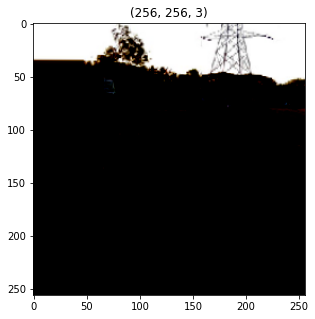

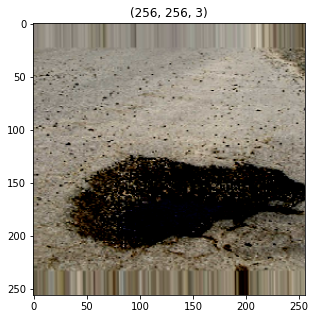

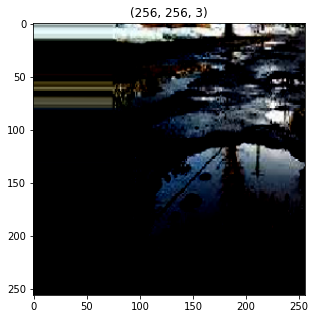

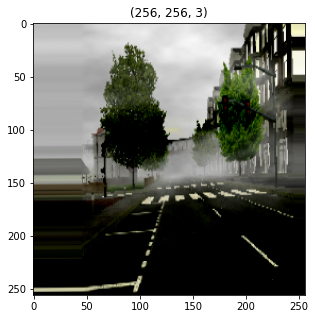

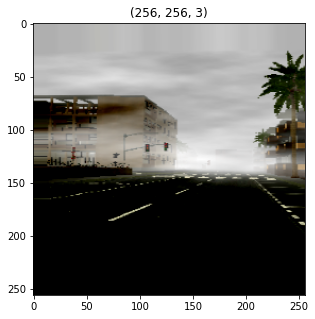

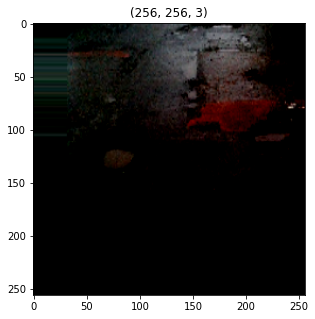

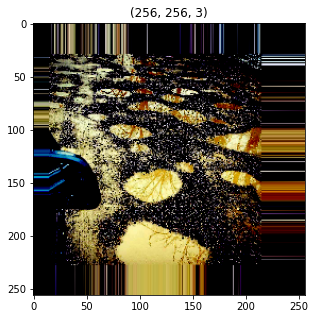

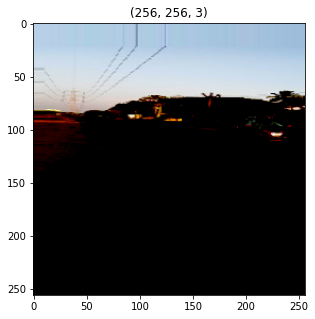

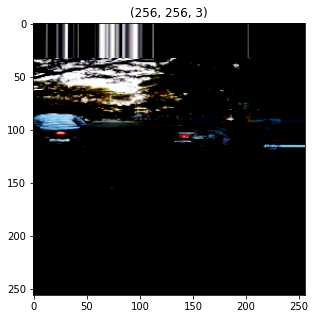

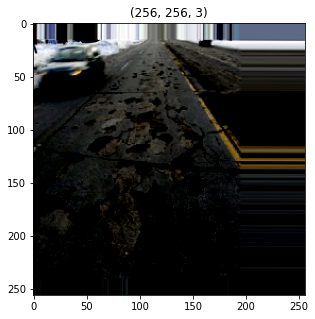

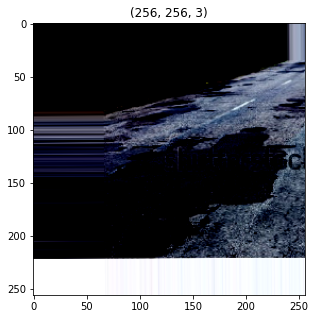

In [28]:
plotImages(t_img, label)

In [29]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

mc = ModelCheckpoint(filepath= "./best_model.h5",
                     monitor= "accuracy",
                     verbose= 1,
                     save_best_only= True)

es= EarlyStopping(monitor= "accuracy",
                  min_delta= 0.01,
                  patience= 5,
                  verbose= 1)

cb= [mc, es]

In [30]:
his= model.fit_generator(train_data, steps_per_epoch= 1, epochs= 30, callbacks= cb)

Epoch 1/30
1/1 [==============================] - ETA: 0s - loss: 0.9195 - accuracy: 0.2656
Epoch 1: accuracy improved from -inf to 0.26562, saving model to ./best_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.9195 - accuracy: 0.2656
Epoch 2/30
1/1 [==============================] - ETA: 0s - loss: 4.2572 - accuracy: 0.5156
Epoch 2: accuracy improved from 0.26562 to 0.51562, saving model to ./best_model.h5
1/1 [==============================] - 2s 2s/step - loss: 4.2572 - accuracy: 0.5156
Epoch 3/30
1/1 [==============================] - ETA: 0s - loss: 3.9234 - accuracy: 0.6250
Epoch 3: accuracy improved from 0.51562 to 0.62500, saving model to ./best_model.h5
1/1 [==============================] - 2s 2s/step - loss: 3.9234 - accuracy: 0.6250
Epoch 4/30
1/1 [==============================] - ETA: 0s - loss: 2.0839 - accuracy: 0.7969
Epoch 4: accuracy improved from 0.62500 to 0.79688, saving model to ./best_model.h5
1/1 [==============================] - 2s 2s/st

In [31]:
from keras.models import load_model

model = load_model("/content/best_model.h5")

In [32]:
h = his.history
h.keys()

dict_keys(['loss', 'accuracy'])

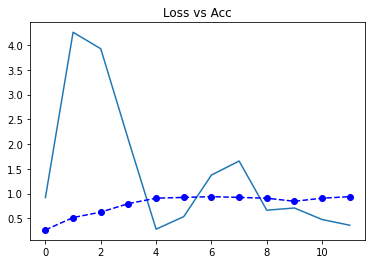

In [33]:
plt.plot(h['loss'])
plt.plot(h['accuracy'],'go--', c = "blue")

plt.title("Loss vs Acc")
plt.show()

In [39]:
path= "/content/test/20.jpg"
img= load_img(path, target_size=(256,256))

i= img_to_array(img)
i= preprocess_input(i)
input_arr= np.array([i])
input_arr.shape

pred= np.argmax(model.predict(input_arr))

if pred == 0:
  print("Fog Detected")
elif pred == 1:
  print("Pothole Detected")
else:
  print("Speed Breaker Ahead")

1/1 [==============================] - 0s 27ms/step
Speed Breaker Ahead
